(d_raster_crs_intro)=


----------------

```{admonition} Learning Objectives
- Learn how rasters are reprojected
- Learn how affine transforms are used 
- Use rasterio to reproject a raster
- Learn about interpolation options during transforms
```
```{admonition} Review
* [Intro to Raster data](c_rasters.md)
* [Affine transformation](d_affine.md)
```
----------------


# Raster Coordinate Reference Systems (CRS)

Raster data is very different that vector data, one of the key differences is that we don't have a pair of coordinates (x,y) for each pixel in a raster. How then do we know where the raster is located in addition to what the data values are? For a new spatial raster (e.g. geotif) we need to store a few other pieces of information seperately. We need to keep track of the location of the upper left hand corner, the resolution (in both the x and y direction) and a description of the coordinate space (i.e. the CRS), amongst others.


```{figure} ../_static/d_crs/warp.png
:name: Example of a warped (reprojected) image
Example of a warped (reprojected) image
```
 
Let's start from the `ndarray` `Z` that we want to span from [-90&deg;,90&deg;] longitude, and [-90&deg;,90&deg;] latitude. For more detail on the construction of these arrays please refer to [the raster section](c_rasters.md).

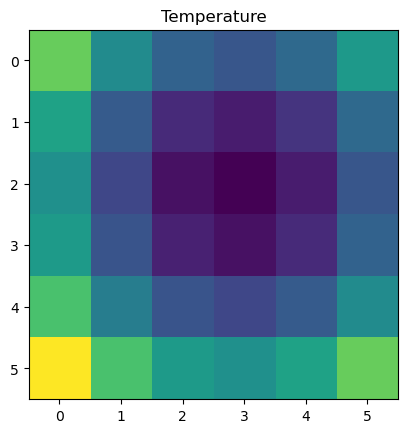

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-90, 90, 6)
y = np.linspace(90, -90, 6)
X, Y = np.meshgrid(x, y)

Z1 =  np.abs(((X - 10) ** 2 + (Y - 10) ** 2) / 1 ** 2)
Z2 =  np.abs(((X + 10) ** 2 + (Y + 10) ** 2) / 2.5 ** 2)
Z =  (Z1 - Z2)

plt.imshow(Z)
plt.title("Temperature")
plt.show()

Note that *`Z` contains no data on its location*. Its just an array, the information stored in `x` and `y` aren't associated with it at all. This location data will often be stored in the header of file. In order to 'locate' the array on the map we will use affine transformations. 

Affine transformations allows us to use simple systems of linear equations to manipulate any point or set of points ([review affine transforms here](d_affine.md)). It allows us to move, stretch, or even rotate a point or set of points. In the case of GIS, it is used to move raster data, a satellite image, to the correct location in the CRS coordinate space.

## Describing the Array Location (Define a Projection)
In this example the coordinate reference system will be '+proj=latlong', which describes an equirectangular coordinate reference system with units of decimal degrees. Although `X` and `Y` seems relevant to understanding the location of cell values, `rasterio` instead uses affine transformations instead. Affine transforms uses matrix algebra to describe where a cell is located (translation) and what its resolution is (scale). [Review affine transformations](d_affine_trans_scale.md) and [see an example here](d_affine_trans.md).

The affine transformation matrix can be computed from the matrix product of a translation (moving N,S,E,W) and a scaling (resolution). First, we start with translation where $\Delta x$ and $\Delta y$ define the location of the upper left hand corner of our new `Z` ndarray. As a reminder the translation matrix takes the form:

$$
   \begin{eqnarray}
     \mbox{Translate} =  \begin{bmatrix} 1 & 0 & \Delta x \\  0 & 1 & \Delta y \\ 0 & 0 & 1 \end{bmatrix}  
   \end{eqnarray}
$$

Now we can define our translation matrix using the point coordinates (`x[0]`,`y[0]`), but these need to be offset by 1/2 the resolution so that the cell is centered over the coordinate (-90,90). Notice however there are some difference between the x and y resolution:

Both arrays have the same spatial resolution

In [2]:
xres = (x[-1] - x[0]) / len(x)
xres

30.0

But notice that the y resolution is **negative**:

In [3]:
yres = (y[-1] - y[0]) / len(y)
yres

-30.0

We need to create our translation matrix by defining the location of the upper left hand corner. Looking back at our definitions of our coordinates `X` and `Y` we can see that they are defined with `x = np.linspace(-90, 90, 6); y = np.linspace(90, -90, 6); X, Y = np.meshgrid(x, y)`, if you run `print(X);print(Y)` you will see that the **center** of the upper left hand corner should be located at (-90,90). The **upper left hand corner** of that same cell is actually further up and to the left than (-90,90). It follows then that that corner should be shifted exactly 1/2 the resolution of the cell, both up and to the left. 

We can therefore define the upper left hand corner by setting $\Delta x = x[0] - xres / 2$ and $\Delta y = y[0] - yres / 2$. Remember yres is negative, so subtraction is correct.

In [4]:
from rasterio.transform import Affine
print(Affine.translation(x[0] - xres / 2, y[0] - yres / 2))

| 1.00, 0.00,-105.00|
| 0.00, 1.00, 105.00|
| 0.00, 0.00, 1.00|


We also need to scale our data based on the resolution of each cell, the scale matrix takes the following form:

$$
   \begin{eqnarray}
   \mbox{Scale} = \begin{bmatrix} xres & 0 & 0 \\ 0 & yres & 0 \\ 0 & 0 & 1 \end{bmatrix} 
   \end{eqnarray}
$$

In [5]:
print(Affine.scale(xres, yres))

| 30.00, 0.00, 0.00|
| 0.00,-30.00, 0.00|
| 0.00, 0.00, 1.00|


We can do both operations simultaneously in a new `transform` matrix by calculating the product of the Translate and Scale matrix: 

$$
    \mbox{Translate} \cdot \mbox{Scale} =  \begin{bmatrix} xres & 0 & \Delta x \\ 0 & yres & \Delta y \\ 0 & 0 & 1 \end{bmatrix} 
$$

In [6]:
transform = Affine.translation(x[0] - xres / 2, y[0] - yres / 2) * Affine.scale(xres, yres)
print(transform)

| 30.00, 0.00,-105.00|
| 0.00,-30.00, 105.00|
| 0.00, 0.00, 1.00|


Now we need to write out a `tif` file that holds the data in `Z` and its data type with `dtype`, the location described by `transform`, in coordinates described by the coordinate reference system `+proj=latlon`, the number of 'bands' of data in `count` (in this case just one), and the shape in `height` and `width`.

In [7]:
import rasterio
with rasterio.open(
    '../temp/Z.tif',
    'w',
    driver='GTiff',
    height=Z.shape[0],
    width=Z.shape[1],
    count=1,
    dtype=Z.dtype,
    crs='+proj=latlong',
    transform=transform,
) as dst:
    dst.write(Z, 1)

All this info is stored in `dst` and then written to disk with `dst.write(Z,1)`. Where `write` gets the array of data `Z` and the band location to write to, in this case band `1`. This is a bit awkward, but I believe is a carryover from GDAL which rasterio relies on heavily (like all other platforms including arcmap etc). 


### The Crazy Tale of the Upper Left Hand Corner
To help us understand what is going on with `transform` it helps to work an example. For our example above we need to define the translate matrix that helps define the upper left hand corner of our rainfall raster data `Z`. In particular we need the upper left cell center to be located at (-90,90), so the upper left hand corner need to be 1/2 the resolution above and to the left of (-90,90), implying a location of (-105,105) since the resolution is 30 degrees.

We can visualize what we need to do here: 

```{figure} ../_static/c_data_types/c_raster_upperleft_drawing.png
:name: Example of using affine translation to shift the upper left hand corner
:width: 500px
Example of using translation to shift the upper left hand corner
```

Let's walk through the math behind the scenes. Here we use our transform matrix to move our upper left hand corner which is assumed to start at the origin (0,0).

```{figure} ../_static/c_data_types/c_raster_upperleft_transform.png
:name: Example of using affine translation of a matrix to shift the upper left hand corner
:width: 500px
Example of using affine translation of a matrix to shift the upper left hand corner
```
The final coordinate of the upper left hand corner are $(x_0,y_0) = (-105,105)$


### Translate is a "map"
Now here's the magic, our new `translate` matrix can be used to easily find the coordinates of any cell based on its row and column number. To see how if works, we are going to multiply our `translate` matrix by `(column_number, row_number)` to retrieve the coordinates of that cell's upper right hand corner. Essentially, `translate` "maps" row and column indexes to coordinates! OMG! This is fun... ok kidding, but it's useful. 

 
Let's see how we can calculate a few coordinates (upper left) based on the visual examples below:

```{figure} ../_static/c_data_types/c_raster_raster.png
:name: Example of using transform to identify coordinates based on row and column
:width: 500px
Example of using transform to identify coordinates based on row and column
```
Let's start with the easiest and retrieve the upper left corner coordinates based on `transform * (row_number, column_number)`:

In [8]:
print(transform*(0,0))

(-105.0, 105.0)


Let's find the corner that is one cell down (-30&deg;) and to the right (+30&deg;)

In [9]:
print(transform*(1,1))

(-75.0, 75.0)


Just to make sure it works let's find a harder one, 5th column right, 2nd row down:

In [10]:
print(transform*(5,2))

(45.0, 45.0)


#### How Transforms Works
Let's work the example of finding the upper left coordinates of with `row=5`, `column=2`:

$$
   \begin{eqnarray}
      \begin{bmatrix} 
          30 & 0 & -105 \\  
          0 & -30 & 105 \\ 
          0 & 0 & 1 
      \end{bmatrix}  
      \begin{bmatrix} 5 \\ 2 \\ 1 \end{bmatrix}   =
      \begin{bmatrix} 
          5 \times 30 + 2 \times 0 + 1 \times -105  \\  
          5 \times 0 + 2 \times -30 + 1 \times 105 \\ 
          5 \times 0 + 2 \times 0 + 1 \times 1  
      \end{bmatrix} = 
      \begin{bmatrix} 45  \\  45 \\ 1  \end{bmatrix}
   \end{eqnarray}
$$

Wow, it works! Come on it's at least a little bit cool. Depending on your definition of cool.

## Reproject a Raster - The Simple Case
How then do we reproject a raster? Since `transform` is a map of pixel locations, warping a raster then becomes as simple as knowing the `transform` of your destination based on the description of the new coordinate reference system (CRS). If you haven't please study [affine transformations](d_affine.md).

### Shifting the Prime Meridian
One of the easiest cases is that of false easting, or moving the prime meridian. Let's walk through an example where we start with a raster with an upper left hand corner at (0, 45), then we will apply a transform to move it to (10, 45) by moving the prime meridian 10&deg; to the west (e.g. using `+lon_0=-10` from the  [proj4string](d_understand_crs_codes.md)). 

Let's start be looking visually at what we plan to do:


```{figure} ../_static/d_crs/d_europe_translate_raster.png
:name: Example of using translate to reproject an image by moving prime meridian
:width: 500px
Example of using translate to reproject an image by moving prime meridian
```


We can then use our knowledge of matrix algebra and transform matrices to solve for the new upper left hand corner coordinate ($x_B$, $y_B$)

```{figure} ../_static/d_crs/d_europe_translate_raster_m.png
:name: Example of using translate matrix to reproject an image by moving prime meridian
:width: 400px
Example of using translate matrix to reproject an image by moving prime meridian
```

## Reproject a Raster - The Complex Case
In many cases reprojecting a raster requires changing the number of rows or columns, or 'warping' (i.e. bending) an image. All of these examples create a problem, the centroids of the new projected raster don't line up with the centroids of the original raster. Therefore they now represent locations on the ground that weren't in the original dataset. 

Take for instance the case of a 'warped' raster image (below) which for instance occurs when you switch from a spherical CRS (like lat lon) to a projected (or flat) CRS. Notice that the centroids of the two rasters no longer over lap:


```{figure} ../_static/d_crs/d_warp.png
:name: Example of warping an image during reprojection
:width: 500px
Example of warping an image during reprojection
```

In this case we have a decision to make, how will we assign values to the new warped raster? Keep in mind the values must change because they now point to different locations on the ground.  For this we have a number of 'interpolation' options, some simple, some complex.

```{note}
What is interpolation? Interpolation allows us to make an informed guess of a value at a new location. [Read more here](http://wiki.gis.com/wiki/index.php/Interpolation)
```

(d_raster_crs_intro_interpolation_options)=

### Interpolation Options
There are three commonly used interpolation methods: a) Nearest neighbor - assigns the value of the nearest centroid, b) bilinear interpolation - uses a straight line between know locations, c) bicubic interpolation - uses curved line between known locations. 

In the visual example below we will try to estimate the value for location `C` based on the known values at locations `A` and `B`. 

```{figure} ../_static/d_crs/d_bilinear.png
:name: Example of nearest neighbor and bilinear interpolation
:width: 500px
Example of nearest neighbor and bilinear interpolation
```


```{figure} ../_static/d_crs/d_bicubic.png
:name: Example of nearest neighbor and bicubic interpolation
:width: 400px
Example of nearest neighbor and bicubic interpolation
```
### Choosing the Right Interpolation Method
Choosing the correct interpolation method is important. The following table should help you to decided. Remember categorical data might include land cover classes (forest, water, etc), and continuous data is measurable for instance rainfall (values 0 to 20mm).

| Method    | Description    |  Fast  |  Categorical  | Continuous |
| :--- | ---: | :--- | ---: |:--- | 
| Nearest<br>Neighbor    | Assigns nearest value    | Y | Y | |
| Bilinear | Linear estimation | Y |  | Y |
| Bicubic | Non-Linear estimation | Most of<br>the time | | Y|

For categorical data, Nearest Neighbor is your only choice, enjoy it. For continuous data, like quantity of rain, you can choose between Bilinear and Bicubic (i.e. "cubic convolution"). For most data Bilinear interpolation is fast and effective. However if you believe your data is highly non-linear, or widely spaced, you might consider using Bicubic. Some experimentation here is often informative. 

## Reprojecting a Raster with Rasterio 
Ok enough talk already, how do we reproject a raster? Before we get into it, we need to talk some more... about `calculate_default_transform`. `calculate_default_transform` allows us to generate the transform matrix required for the new reprojected raster based on the characteristics of the original and the desired output CRS. Note that the `source` (src) is the original input raster, and the `destination` (dst) is the outputed reprojected raster. 

First, remember that the transform matrix takes the following form:

$$
    \mbox{Transform} =  \begin{bmatrix} xres & 0 & \Delta x \\ 0 & yres & \Delta y \\ 0 & 0 & 1 \end{bmatrix} 
$$

Now let's calculate the tranform matrix for the destination raster:

In [11]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform

dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:

    # transform for input raster
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,    # source CRS
        dst_crs,    # destination CRS
        src.width,    # column count
        src.height,  # row count
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

print("Source Transform:\n",src_transform,'\n')
print("Destination Transform:\n", dst_transform)

Source Transform:
 | 30.00, 0.00, 717345.00|
| 0.00,-30.00,-2776995.00|
| 0.00, 0.00, 1.00| 

Destination Transform:
 | 33.24, 0.00,-6105300.09|
| 0.00,-33.24,-2885952.71|
| 0.00, 0.00, 1.00|


Notice that in order to keep the same number of rows and columns that the resolution of the destination raster increased from 30 meters to 33.24 meters. Also the coordinates of the upper left hand corner have shifted (check $\Delta x, \Delta x$).

Ok finally!

In [12]:
dst_crs = "EPSG:3857"  # web mercator(ie google maps)

with rasterio.open("../data/LC08_L1TP_224078_20200518_20200518_01_RT.TIF") as src:
    src_transform = src.transform

    # calculate the transform matrix for the output
    dst_transform, width, height = calculate_default_transform(
        src.crs,
        dst_crs,
        src.width,
        src.height,
        *src.bounds,  # unpacks outer boundaries (left, bottom, right, top)
    )

    # set properties for output
    dst_kwargs = src.meta.copy()
    dst_kwargs.update(
        {
            "crs": dst_crs,
            "transform": dst_transform,
            "width": width,
            "height": height,
            "nodata": 0,  # replace 0 with np.nan
        }
    )

    with rasterio.open("../temp/LC08_20200518_webMC.tif", "w", **dst_kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=dst_transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest,
            )

```{figure} ../_static/d_crs/d_reproj_image.png
:name: Reprojected Landsat Image
:width: 400px
Reprojected Landsat Image
```

Source: [Creating Raster Data](https://rasterio.readthedocs.io/en/latest/quickstart.html?highlight=X%2C%20Y%20%3D%20np.meshgrid(x%2C%20y)#creating-data)

<!-- 
6.6 Reprojecting raster geometries

The projection concepts described in the previous section apply equally to rasters. However, there are important differences in reprojection of vectors and rasters: transforming a vector object involves changing the coordinates of every vertex but this does not apply to raster data. Rasters are composed of rectangular cells of the same size (expressed by map units, such as degrees or meters), so it is impossible to transform coordinates of pixels separately. Raster reprojection involves creating a new raster object, often with a different number of columns and rows than the original. The attributes must subsequently be re-estimated, allowing the new pixels to be ‘filled’ with appropriate values. In other words, raster reprojection can be thought of as two separate spatial operations: a vector reprojection of cell centroids to another CRS (Section 6.4), and computation of new pixel values through resampling (Section 5.3.3). Thus in most cases when both raster and vector data are used, it is better to avoid reprojecting rasters and reproject vectors instead.

The raster reprojection process is done with projectRaster() from the raster package. Like the st_transform() function demonstrated in the previous section, projectRaster() takes a geographic object (a raster dataset in this case) and a crs argument. However, projectRaster() only accepts the lengthy proj4string definitions of a CRS rather than concise EPSG codes.
It is possible to use a EPSG code in a proj4string definition with "+init=epsg:MY_NUMBER". For example, one can use the "+init=epsg:4326" definition to set CRS to WGS84 (EPSG code of 4326). The PROJ library automatically adds the rest of the parameters and converts them into "+init=epsg:4326 +proj=longlat +datum=WGS84 +no_defs +ellps=WGS84 +towgs84=0,0,0".

Let’s take a look at two examples of raster transformation: using categorical and continuous data. Land cover data are usually represented by categorical maps. The nlcd2011.tif file provides information for a small area in Utah, USA obtained from National Land Cover Database 2011 in the NAD83 / UTM zone 12N CRS.

cat_raster = raster(system.file("raster/nlcd2011.tif", package = "spDataLarge"))
#> Warning in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj
#> = prefer_proj): Discarded datum Unknown based on GRS80 ellipsoid in Proj4
#> definition
crs(cat_raster)
#> CRS arguments:
#>  +proj=utm +zone=12 +ellps=GRS80 +units=m +no_defs

In this region, 14 land cover classes were distinguished (a full list of NLCD2011 land cover classes can be found at mrlc.gov):

unique(cat_raster)
#>  [1] 11 21 22 23 31 41 42 43 52 71 81 82 90 95

When reprojecting categorical rasters, the estimated values must be the same as those of the original. This could be done using the nearest neighbor method (ngb). This method sets each new cell value to the value of the nearest cell (center) of the input raster. An example is reprojecting cat_raster to WGS84, a geographic CRS well suited for web mapping. The first step is to obtain the PROJ definition of this CRS, which can be done using the http://spatialreference.org webpage. The final step is to reproject the raster with the projectRaster() function which, in the case of categorical data, uses the nearest neighbor method (ngb):

wgs84 = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"
cat_raster_wgs84 = projectRaster(cat_raster, crs = wgs84, method = "ngb")

Many properties of the new object differ from the previous one, including the number of columns and rows (and therefore number of cells), resolution (transformed from meters into degrees), and extent, as illustrated in Table 6.1 (note that the number of categories increases from 14 to 15 because of the addition of NA values, not because a new category has been created — the land cover classes are preserved).
TABLE 6.1: Key attributes in the original (‘cat_raster’) and projected (‘cat_raster_wgs84’) categorical raster datasets. CRS 	nrow 	ncol 	ncell 	resolution 	unique_categories
NAD83 	1359 	1073 	1458207 	31.5275 	14
WGS84 	1394 	1111 	1548734 	0.0003 	15

Reprojecting numeric rasters (with numeric or in this case integer values) follows an almost identical procedure. This is demonstrated below with srtm.tif in spDataLarge from the Shuttle Radar Topography Mission (SRTM), which represents height in meters above sea level (elevation) with the WGS84 CRS:

con_raster = raster(system.file("raster/srtm.tif", package = "spDataLarge"))
crs(con_raster)
#> CRS arguments: +proj=longlat +datum=WGS84 +no_defs

We will reproject this dataset into a projected CRS, but not with the nearest neighbor method which is appropriate for categorical data. Instead, we will use the bilinear method which computes the output cell value based on the four nearest cells in the original raster. The values in the projected dataset are the distance-weighted average of the values from these four cells: the closer the input cell is to the center of the output cell, the greater its weight. The following commands create a text string representing the Oblique Lambert azimuthal equal-area projection, and reproject the raster into this CRS, using the bilinear method:

equalarea = "+proj=laea +lat_0=37.32 +lon_0=-113.04"
con_raster_ea = projectRaster(con_raster, crs = equalarea, method = "bilinear")
crs(con_raster_ea)
#> CRS arguments:
#>  +proj=laea +lat_0=37.32 +lon_0=-113.04 +x_0=0 +y_0=0 +datum=WGS84
#> +units=m +no_defs

Raster reprojection on numeric variables also leads to small changes to values and spatial properties, such as the number of cells, resolution, and extent. These changes are demonstrated in Table 6.230:
TABLE 6.2: Key attributes in the original (‘con_raster’) and projected (‘con_raster_ea’) continuous raster datasets. CRS 	nrow 	ncol 	ncell 	resolution 	mean
WGS84 	457 	465 	212505 	0.0008 	1843
Equal-area 	467 	478 	223226 	83.2000 	1842
Of course, the limitations of 2D Earth projections apply as much to vector as to raster data. At best we can comply with two out of three spatial properties (distance, area, direction). Therefore, the task at hand determines which projection to choose. For instance, if we are interested in a density (points per grid cell or inhabitants per grid cell) we should use an equal-area projection (see also Chapter 13).

There is more to learn about CRSs. An excellent resource in this area, also implemented in R, is the website R Spatial. Chapter 6 for this free online book is recommended reading — see: rspatial.org/spatial/6-crs.html -->